In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/Heteroskedastic_CelebA_Ppc/0724_015002/checkpoint_2099.ckpt")

Missing logger folder: saved/log/Heteroskedastic_CelebA_Ppc/0725_223623/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0725_223623 exists and is not empty.
Restoring states from the checkpoint path at saved/models/Heteroskedastic_CelebA_Ppc/0724_015002/checkpoint_2099.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:360: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0724_015002' to '/workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0725_223623', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | graph      | Gener

Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
`Trainer.fit` stopped: `max_epochs=2100` reached.


In [7]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): GeneratorPpc(
    (prior): GaussianPrior()
    (likelihood): ConvolutionalDecoder(
      (linear): Sequential(
        (0): Linear(in_features=40, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): SiLU()
      )
      (convs): Sequential(
        (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): SiLU()
        (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): SiLU()
        (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (8): SiLU()
        (9): ConvTranspose2d(32, 32, kernel_size=(4, 4), s

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [9]:
with model.graph.condition(X=xs) as joint:
    for i in range(299):
        trace, log_weight = joint(B=len(xs), lr=8e-4, P=model.num_particles)
        logger.info("Free energy at evaluation %d: %f" % (i+1, -log_weight.mean()))
        del trace
        del log_weight
    _, log_weight = joint(B=len(xs), lr=8e-4, P=model.num_particles)
logger.info("Free energy at evaluation 300: %f" % -log_weight.mean())
del log_weight

Free energy at evaluation 1: 38313.585938
Free energy at evaluation 2: 57425.843750
Free energy at evaluation 3: 27542.253906
Free energy at evaluation 4: 24962.556641
Free energy at evaluation 5: 18307.333984
Free energy at evaluation 6: 12884.102539
Free energy at evaluation 7: 10721.695312
Free energy at evaluation 8: 6775.045898
Free energy at evaluation 9: 5247.779785
Free energy at evaluation 10: 4319.572266
Free energy at evaluation 11: 3644.534912
Free energy at evaluation 12: 3276.045410
Free energy at evaluation 13: 3030.190918
Free energy at evaluation 14: 3019.670410
Free energy at evaluation 15: 2913.041016
Free energy at evaluation 16: 2734.964111
Free energy at evaluation 17: 2433.067383
Free energy at evaluation 18: 2208.969971
Free energy at evaluation 19: 1885.088623
Free energy at evaluation 20: 1742.483887
Free energy at evaluation 21: 1535.264648
Free energy at evaluation 22: 1343.484375
Free energy at evaluation 23: 1146.482422
Free energy at evaluation 24: 1113.5

In [10]:
with model.graph.condition(z=model.graph.nodes['z']['value']) as predictive:
    x_hats = predictive(B=len(xs), mode="prior", P=model.num_particles).mean(dim=0)

In [11]:
import matplotlib.pyplot as plt

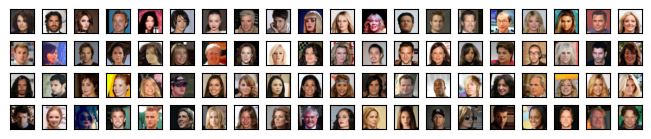

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        orgs = data.reverse_transform(xs[row * 20 + col].detach().cpu()).transpose(0, -1)
        axes[row, col].imshow(orgs)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_orgs.pdf", bbox_inches="tight")
plt.show()

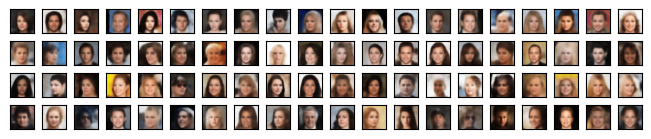

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [14]:
del xs
del x_hats

In [15]:
model.graph.clear()

In [16]:
posterior = {k: torch.cat((v.detach(), model.particles["valid"][k].detach()), dim=1)
             for k, v in model.particles["train"].items()}
x_hats = model.graph.predict(B=80 // model.num_particles, P=model.num_particles, **posterior)
x_hats = torch.flatten(x_hats, 0, 1)

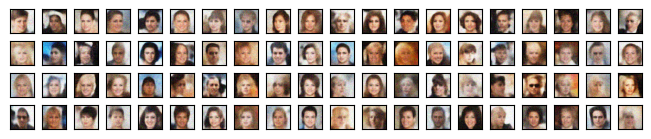

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].squeeze().detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_predictive.pdf", bbox_inches="tight")
plt.show()

In [18]:
del x_hats

In [19]:
model.graph.clear()

In [20]:
model.graph(B=80 // model.num_particles, lr=8e-4, mode="prior", P=model.num_particles)
for _ in range(299):
    model.graph(B=80 // model.num_particles, lr=8e-4, P=model.num_particles)
x_hats = model.graph(B=80 // model.num_particles, lr=8e-4, mode="prior", P=model.num_particles)
x_hats = x_hats.flatten(0, 1)

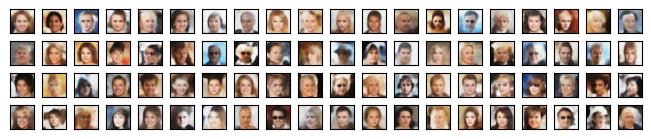

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].squeeze().detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_priors.pdf", bbox_inches="tight")
plt.show()

In [22]:
del x_hats

In [23]:
SEEDS = [123, 456, 789, 101112, 131415]

In [24]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [25]:
with torch.no_grad():
    for (s, SEED) in enumerate(SEEDS):
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        for b, (xs, target, indices) in enumerate(data.val_dataloader()):
            xs = xs.to(model.device)
            model._load_particles(indices, False)
            x_hats = model.graph(B=len(xs), mode="prior", P=model.num_particles)
            with model.graph.condition(X=xs) as predictive:
                trace, _ = predictive(B=len(xs), P=model.num_particles)
            LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum().cpu()
            MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean().cpu()
    
            del xs
            del x_hats
            del trace
            del target
            del indices
            logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))
    
        LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset)
        MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0
Evaluated likelihood for valid batch 5 under seed 0
Evaluated likelihood for valid batch 6 under seed 0
Evaluated likelihood for valid batch 7 under seed 0
Evaluated likelihood for valid batch 8 under seed 0
Evaluated likelihood for valid batch 9 under seed 0
Evaluated likelihood for valid batch 10 under seed 0
Evaluated likelihood for valid batch 11 under seed 0
Evaluated likelihood for valid batch 12 under seed 0
Evaluated likelihood for valid batch 13 under seed 0
Evaluated likelihood for valid batch 14 under seed 0
Evaluated likelihood for valid batch 15 under seed 0
Evaluated likelihood for valid batch 16 under seed 0
Evaluated likelihood for valid batch 17 under seed 0
Evaluated likelihood for valid batch 18 under seed 0
Eva

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 4 under seed 1
Evaluated likelihood for valid batch 5 under seed 1
Evaluated likelihood for valid batch 6 under seed 1
Evaluated likelihood for valid batch 7 under seed 1
Evaluated likelihood for valid batch 8 under seed 1
Evaluated likelihood for valid batch 9 under seed 1
Evaluated likelihood for valid batch 10 under seed 1
Evaluated likelihood for valid batch 11 under seed 1
Evaluated likelihood for valid batch 12 under seed 1
Evaluated likelihood for valid batch 13 under seed 1
Evaluated likelihood for valid batch 14 under seed 1
Evaluated likelihood for valid batch 15 under seed 1
Evaluated likelihood for valid batch 16 under seed 1
Evaluated likelihood for valid batch 17 under seed 1
Evaluated likelihood for valid batch 18 under seed 1
Eva

In [26]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-562153.1250), tensor(4242.7202))

In [27]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0197), tensor(1.5549e-05))

In [28]:
model.graph.clear()

In [29]:
import tqdm

In [30]:
fids = []
data.setup("test")

for f in range(10):
    for b, batch in enumerate(tqdm.tqdm(data.test_dataloader(), desc='Test set FIDs')):
        model.test_step(batch, b)
    fids.append(model.metrics['fid'].compute())
    model.metrics['fid'].reset()
    model.graph.gmm = None

fids = torch.stack(fids, dim=0)
fids.mean(), fids.std()

Files already downloaded and verified


Test set FIDs:   0%|                                                                                                                                                                                                                                                                                                                                                   | 0/39 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Test set FIDs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

(tensor(217.0540), tensor(0.5100))